# Plastic Thermal Oxidation Example
This page runs a process model for the thermal oxidation of plastics using Biosteam. 

Click on the menu Runtime-> Run All to run the complete analysis or press shift+enter on each cell.

In [34]:
#@title
!pip install biosteam &> /dev/null

In [35]:
#@title
!pip install llvmlite --upgrade &> /dev/null

In [36]:
import biosteam as bst
from biosteam import units
from chemicals.identifiers import CAS_from_any, search_chemical

In [37]:
#@title
#@Pyrolysis

class PlasticTOD(bst.Unit):
    _N_ins = 1
    _N_outs = 1
    _N_heat_utilities = 1
    _BM = {'Heaters':1}
    _units = {'Area', 'm^2'}
    
    def __init__(self, ID='', ins=None, outs=(), yields=None, *args, **kwargs):
        bst.Unit.__init__(self, ID, ins, outs, bst.settings.get_thermo())
        self._multistream = bst.MultiStream(None, thermo=self.thermo)
        self._multistream.T = self.ins[0].T
        self.yields = yields
        
    def _setup(self):
        vap = self.outs[0]
        vap.phase = 'g'
        
    def _run(self):
        feed = self.ins[0]
        vap = self.outs[0]
        
        z_mass_biooil =  self.yields
        
        ms = self._multistream
        ms.imass['g'] = feed.F_mass*z_mass_biooil
        vap.mass[:] = feed.F_mass*z_mass_biooil
        vap.T = feed.T
        vap.P = feed.P
        ms.empty()


    def _design(self):
        # Calculate heat utility requirement (please read docs for HeatUtility objects)
        T_operation = self._multistream.T
        duty = self.H_out - self.H_in
        if duty < 0:
            raise RuntimeError(f'{repr(self)} is cooling.')
        hu = self.heat_utilities[0]
        hu(duty, T_operation)

        # Temperature of utility at entrance
        # T_utility = hu.inlet_utility_stream.T
        T_utility = 298.15

        # Temeperature gradient
        dT = T_utility - T_operation

        # Heat transfer coefficient kJ/(hr*m2*K)
        U = 8176.699

        print(duty, U, dT)
        # Area requirement (m^2)
        # A = duty/(U*dT)
        A = 1

        # Maximum area per unit
        A_max = 743.224

        # Number of units
        N = max([int(A/A_max),1])

        # Design requirements are stored here
        self.design_results['Area'] = A/N
        self.design_results['N'] = N

    def _cost(self):
        A = self.design_results['Area']
        N = self.design_results['N']

        # Long-tube vertical boiler cost correlation from
        # "Product process and design". Warren et. al. (2016) Table 22.32, pg 592
        purchase_cost = N*bst.CE*3.086*A**0.55

        # Itemized purchase costs are stored here
        self.purchase_costs['Pyrolyzer'] = purchase_cost

class Cyclone(bst.Unit):
    _N_ins = 1
    _N_outs = 2
    _N_heat_utilities = 0
    _BM = {'Heaters':1}
    _units = {'Area', 'm^2'}
    
    def __init__(self, ID='', ins=None, outs=(), efficiency=0.99, *args, **kwargs):
        bst.Unit.__init__(self, ID, ins, outs, bst.settings.get_thermo())
        self._multistream = bst.MultiStream(None, thermo=self.thermo, phases=['g', 'l', 's'])
        self.efficiency = efficiency
        self.T = self.ins[0].T
        self.P = self.ins[0].P
        self._BM = {'Heaters':1}
        
    def _setup(self):
        vap, sol = self.outs
        vap.phase = 'g'
        sol.phase = 's'
        
    def _run(self):
        feed = self.ins[0]
        vap = self.outs[0]
        sol = self.outs[1]
        
        ms = self._multistream
        ms.imol['g'] = feed.mol
        for k in ms.available_chemicals:
            if k.get_phase(T=feed.T, P=feed.P) == 's':
                sol.imol[ str(k)] = ms.imol['g', str(k)]*self.efficiency
                vap.imol[ str(k)] = ms.imol['g',  str(k)]*(1-self.efficiency)
            else:
                vap.imol[ str(k)] = ms.imol['g',  str(k)]

#         vap.mol[:] = ms.imol['l']
#         sol.mol[:] = ms.imol['s']
        
        vap.T = self.T
        vap.P = self.P
        
        sol.T = self.T
        sol.P = self.P
        
        ms.empty()

    def _design(self):

        # Design requirements are stored here
        self.design_results['Area'] = 0
        self.design_results['N'] = 0

    def _cost(self):
        # Design requirements are stored here
        self.design_results['Area'] = 0
        self.design_results['N'] = 0

        # Itemized purchase costs are stored here
        self.purchase_costs['Cyclone'] = 0


# Key Assumptions
## Plastic Composition

In [38]:
x_PET = 0.3 #@param {type: "number"}
x_PE = 0.3 #@param {type: "number"}
x_PP = 0.3 #@param {type: "number"}
x_Al = 1 - x_PET - x_PE - x_PP

plastic_composition = dict(PET = x_PET, 
                          PE = x_PE, 
                          PP = x_PP, 
                          Al = x_Al)

## Pyrolysis Yields


In [39]:
# ToDo: Model pyrolysis yields as a function of plastic composition, operating
# conditions, and catalyst
pyrolysis_yields = dict(CO2 = 0.10,
                        Benzene=0.51,
                        Heptane=0.13,
                        Heptene=0.16,
                        Water=0.05,
                        PET=0.02,
                        PE=0.02,
                        PP=0.01)



In [40]:
def define_chemical_phase(chemical, phase, **constants):
    c = bst.Chemical(chemical)
    c.at_state(phase=phase)
    return c

In [41]:
# %% Define common chemicals
# PET = "PubChem=8441"
# PP = "PubChem=76958"
# PE = "CAS=9002-88-4"
# Carbon = "PubChem=5462310"
# Aluminum = "PubChem=5359268"
# Heptene = "PubChem=11610"
customChemicals = {
    "PET":"C10H10O4",
    "PP" : "C22H42O3",
    "PE" : "C2H4",
    "Carbon" : "C",
    "Al" : "Al"
}

# Gases
(CH4, CO2, O2) = [ define_chemical_phase(c, 'g')
    for c in ["CH4", 'CO2',  'O2']]

# Fluids
(Heptane, Benzene, Heptene, H2O) = [ c
    for c in bst.Chemicals(['Heptane', 'Benzene', "C7H14", "Water"])]

# Solids
(PET, PP, PE, Char, Al) = [define_chemical_phase(c, 's') 
    for c in customChemicals.values()]

# Use the PE model for the PP saturation pressure model
[PP.Psat.add_model(p) for p in PE.Psat] 

chemicals = bst.Chemicals([CH4, H2O, CO2, O2, PET, PP, PE, Char, Al, Benzene, Heptane, Heptene], cache=True)
for chemical in chemicals:
    chemical.default()

chemicals.compile()
for (k,v) in customChemicals.items():
    chemicals.set_synonym(v, k)

chemicals.set_synonym("C7H14", "Heptene")
bst.settings.set_thermo(chemicals, cache=True)

In [42]:
bst.CE = 567 # 2013
bst.PowerUtility.price = 0.065
HeatUtility = bst.HeatUtility
# Steam is produced on-site by a boiler,
# so make it the only available heating agent.
steam_utility = HeatUtility.get_agent('high_pressure_steam')
HeatUtility.heating_agents = [steam_utility]
steam_utility.heat_transfer_efficiency = 0.85
steam_utility.regeneration_price = 0.30626
steam_utility.T = 529.2
steam_utility.P = 44e5

# Cooling water and chilled water are regenerated by
# on-site facilities. The regeneration and heat transfer
# prices are given accounted for by the capital cost and
# electricity consumption of these facilities
HeatUtility.get_agent('cooling_water').regeneration_price = 0
HeatUtility.get_agent('chilled_water').heat_transfer_price = 0

# Raw material price (USD/kg)
price = {'Plastic': -55.36/1000,
         'Water': 0, # 0.000353,
         'Polymer': 0, # Not significant
         'Steam': 0, # 0.017,
         'Metals': 330/1000,
         'Aromatics': 665/1000,
         'Olefins': 600/1000,
         'Solids': 20/1000} # 

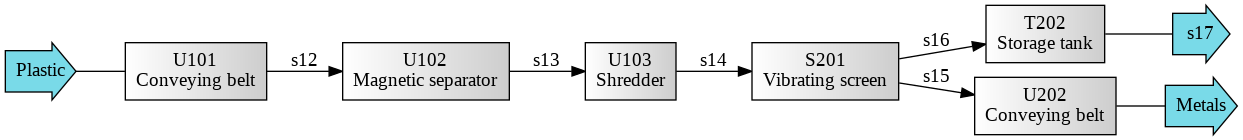

System: pretreatment
 path: (U101, U102, U103, S201, T202, U202)


In [43]:
bst.main_flowsheet.set_flowsheet('pretreatment')

z_mass_plastic = chemicals.kwarray(
    plastic_composition
)

plastic = bst.Stream('Plastic',
                       flow=250000 * z_mass_plastic,
                       units='kg/day',
                       price=price['Plastic'])

u101 = units.ConveyingBelt('U101', ins=plastic)
# Separatate metals
u102 = units.MagneticSeparator('U102', ins=u101-0)
# Shredder
u103 = units.Shredder('U103', ins=u102-0)

# u201 = units.CrushingMill('U201', split=dict(PET=0.9, PE=0.9, PP=0.9, Al=0.1), moisture_content=0)

# Screen out fibers
s201 = units.VibratingScreen('S201', ins=u103-0,
                             split=dict(PET=0.01, PE=0.01, PP=0.01, Al=0.99), outs=('', ''))

waste = bst.Stream('Metals', price=price["Metals"])
u202 = units.ConveyingBelt('U202', ins=s201-0, outs=waste)

# Store juice before treatment
t202 = units.StorageTank('T202', tau=4, vessel_material='Carbon steel', ins=s201-1)


# plastic-u101-u103-S201-0-T202
# S201-1-u202

pretreatment_sys = bst.main_flowsheet.create_system('pretreatment')
pretreatment_sys.diagram('thorough')
pretreatment_sys.show()

In [44]:
bst.main_flowsheet.set_flowsheet('conversion')

c101 = PlasticTOD('C101', ins=t202-0, yields=chemicals.kwarray(
    pyrolysis_yields
    ))


c102 = Cyclone('C102', ins=c101-0, outs=('', 'SolidWaste'), efficiency=0.99)

conversion_sys = bst.main_flowsheet.create_system('conversion')
conversion_sys.diagram()
conversion_sys.show()

System: conversion
 path: ()


In [45]:
bst.main_flowsheet.set_flowsheet('recovery')

# bst.settings.set_thermo((c102-0).chemicals)

r101 = units.HXutility('r101', ins=c102-0, outs=(), T=120+273.15, rigorous=False)

olefins = bst.Stream('Olefins', price=price["Olefins"])
r102 = units.Flash('r102', ins=r101-0, outs=('', olefins), T=120+273.15, P = 101325)
r103 = units.Flash('r103', ins=r102-0, outs=('ncg', ''), T=30+273.15, P = 101325)

aromatics = bst.Stream('Aromatics', price=price["Aromatics"])
r104 = units.LLEUnit('r104', ins=r103-1, outs=(aromatics, 'Wastewater'))

recovery_sys = bst.main_flowsheet.create_system('recovery')
recovery_sys.diagram()
recovery_sys.show()


System: recovery
 path: ()


4144631.923928854 8176.699 0.0


/usr/local/lib/python3.6/dist-packages/biosteam/units/design_tools/pressure_vessel.py:79: CostWarning: <Flash: r102> Vertical vessel weight (1608 lb) is out of bounds (4200 to 1e+06 lb).
  return method(pressure, diameter, length)
/usr/local/lib/python3.6/dist-packages/biosteam/units/design_tools/pressure_vessel.py:79: CostWarning: <Flash: r102> Vertical vessel length (6.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)
sys:1: DesignWarning: <ConveyingBelt: U202> Flow rate (37.84 kg/hr) is out of bounds (minimum 3 kg/hr).
/usr/local/lib/python3.6/dist-packages/biosteam/units/design_tools/pressure_vessel.py:79: CostWarning: <Flash: r103> Vertical vessel weight (3671 lb) is out of bounds (4200 to 1e+06 lb).
  return method(pressure, diameter, length)
/usr/local/lib/python3.6/dist-packages/biosteam/units/design_tools/pressure_vessel.py:79: CostWarning: <Flash: r103> Vertical vessel length (75.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, d

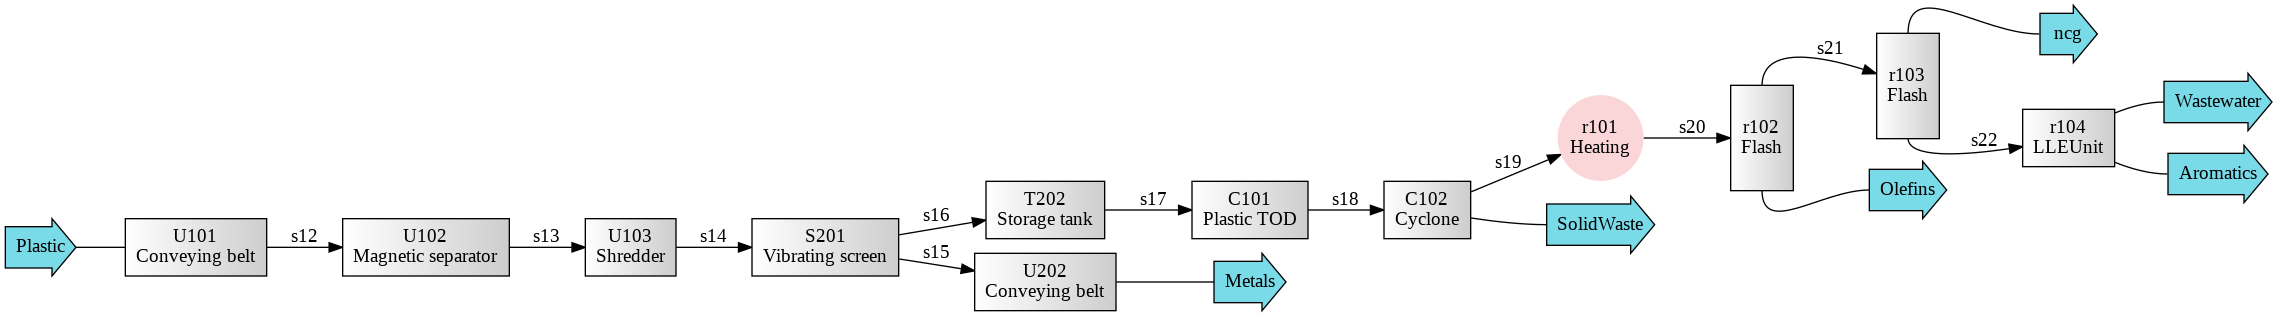

System: facility_sys
 path: (U101, U102, U103, S201, T202, C101,
        C102, r101, r102, r103, r104, U202)


In [46]:
facility_flowsheet = bst.main_flowsheet.from_flowsheets('facility_flowsheet', 
    ['pretreatment', 'conversion', 'recovery']
)

facility_sys = facility_flowsheet.create_system('facility_sys')  
facility_sys.simulate() 
facility_sys.diagram('thorough')  
facility_sys.show() 

In [47]:
class PyrolysisTEA(bst.TEA):
    """
    Create a TEA object for techno-economic analysis of a biorefinery.
    """

    __slots__ = ('labor_cost', 'fringe_benefits', 'maintenance',
                 'property_tax', 'property_insurance', '_FCI_cached',
                 'supplies', 'maintanance', 'administration')

    def __init__(self, system, IRR, duration, depreciation, income_tax,
                 operating_days, lang_factor, construction_schedule, WC_over_FCI,
                 labor_cost, fringe_benefits, property_tax,
                 property_insurance, supplies, maintenance, administration):
        super().__init__(system, IRR, duration, depreciation, income_tax,
                         operating_days, lang_factor, construction_schedule,
                         startup_months=0, startup_FOCfrac=0, startup_VOCfrac=0,
                         startup_salesfrac=0, finance_interest=0, finance_years=0,
                         finance_fraction=0, WC_over_FCI=WC_over_FCI)
        self.labor_cost = labor_cost
        self.fringe_benefits = fringe_benefits
        self.property_tax = property_tax
        self.property_insurance = property_insurance
        self.supplies= supplies
        self.maintenance = maintenance
        self.administration = administration

    def _DPI(self, installed_equipment_cost):
        return 1.02e8
        # return installed_equipment_cost

    def _TDC(self, DPI):
        return DPI

    def _FCI(self, TDC):
        self._FCI_cached = TDC
        return TDC

    def _FOC(self, FCI):
        return (FCI*(self.property_tax + self.property_insurance
                     + self.maintenance + self.administration)
                + self.labor_cost*(1+self.fringe_benefits+self.supplies))

pyrolysis_tea = PyrolysisTEA(system=facility_sys,
                             IRR=0.10,
                             duration=(2018, 2038),
                             depreciation='MACRS7',
                             income_tax=0.35,
                             operating_days=330,
                             lang_factor=3.73,
                             construction_schedule=(0.08, 0.6, 0.32),
                             WC_over_FCI=0.05,
                             labor_cost=8.48e6,
                             fringe_benefits=0.4,
                             property_tax=0.001,
                             property_insurance=0.005,
                             supplies=0.20,
                             maintenance=0.01,
                             administration=0.005)

# pyrolysis_tea.IRR = pyrolysis_tea.solve_IRR()
pyrolysis_tea.show()

PyrolysisTEA: facility_sys
 NPV: 80,491,194 USD at 10.0% IRR


In [48]:
m = pyrolysis_tea.get_cashflow_table()
m

,Depreciable capital [MM$],Fixed capital investment [MM$],Working capital [MM$],Depreciation [MM$],Loan [MM$],...,Net earnings [MM$],Cash flow [MM$],Discount factor,Net present value (NPV) [MM$],Cumulative NPV [MM$]
2015,8.16,8.16,0,0,0,...,0,-8.16,1.21,-9.87,-9.87
2016,61.2,61.2,0,0,0,...,0,-61.2,1.1,-67.3,-77.2
2017,32.6,32.6,5.1,0,0,...,0,-37.7,1,-37.7,-115
2018,0,0,0,14.6,0,...,10.4,24.9,0.909,22.7,-92.3
2019,0,0,0,25,0,...,3.6,28.6,0.826,23.6,-68.6
2020,0,0,0,17.8,0,...,8.24,26.1,0.751,19.6,-49
2021,0,0,0,12.7,0,...,11.6,24.3,0.683,16.6,-32.4
2022,0,0,0,9.11,0,...,13.9,23,0.621,14.3,-18.1
2023,0,0,0,9.1,0,...,13.9,23,0.564,13,-5.15
2024,0,0,0,9.11,0,...,13.9,23,0.513,11.8,6.67


In [59]:
products = [bst.main_flowsheet("Plastic"), bst.main_flowsheet('Aromatics'), bst.main_flowsheet('Olefins'), bst.main_flowsheet('Metals')]
pyrolysis_tea.production_cost(products)

array([-2.036e+06,  1.749e+07,  9.843e+03,  1.311e+06])

In [53]:
# with pd.ExcelWriter('cuwp.xlsx') as writer:
#     m.to_excel(writer)